In [ ]:
#En caso de ImportError: cannot import name 'ops' from 'tensorflow.keras' colab:
!pip install --upgrade keras

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
# Helper libraries
import os
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import heapq
import glob
import sklearn
import random

from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import ops
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.applications import convnext
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/My Drive/CC_Thesis_DP/datasets/cifar/cifar-100-python/cifarTraining_png_images.zip", 'r')
zip_ref.extractall("/content/CC_Thesis_DP/datasets/cifar/cifar-100-python/cifarTraining_png_images/")
zip_ref.close()
os.chdir('/content/CC_Thesis_DP')

In [ ]:
cache_dir = Path.cwd() / "datasets/cifar/cifar-100-python/cifarTraining_png_images"
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

target_shape = (32, 32)

In [ ]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [ ]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# To generate the list of negative images, let's randomize the list of
# available images and concatenate them together.
rng = np.random.RandomState(seed=42)
rng.shuffle(anchor_images)
rng.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

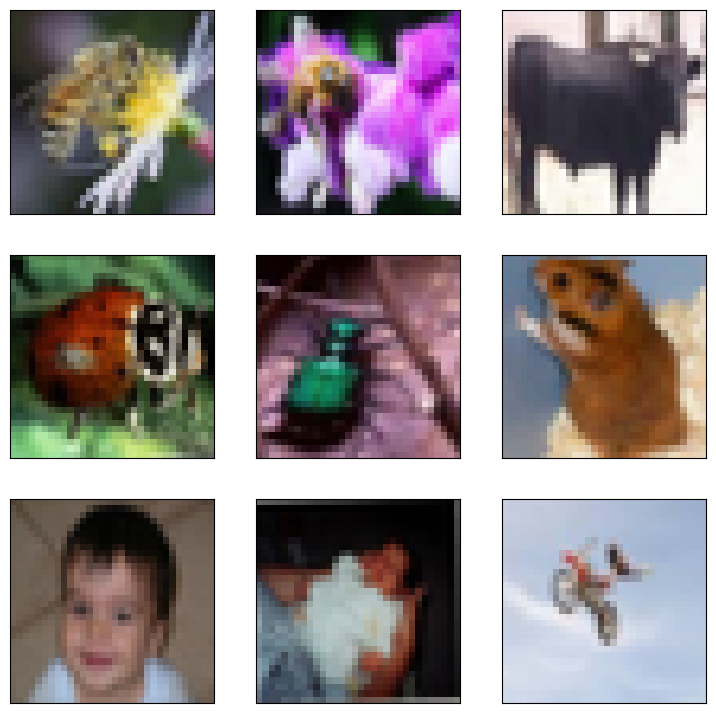

In [ ]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [ ]:
#base_cnn = resnet.ResNet50(
 #   weights="imagenet", input_shape=target_shape + (3,),include_top=False
#)
base_cnn = tf.keras.applications.ConvNeXtSmall(
    weights="imagenet", input_shape=target_shape + (3,),include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "layer_normalization":
    #if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(convnext.preprocess_input(anchor_input)),
    embedding(convnext.preprocess_input(positive_input)),
    embedding(convnext.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [ ]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [ ]:
checkpoint_filepath = Path.cwd() / 'datasets/cifar/cifar-100-python/checkpoint.weights.h5'


model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 104s 135ms/step - loss: 0.4001 - val_loss: 0.4436
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3922 - val_loss: 0.4443
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3960 - val_loss: 0.4508
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3950 - val_loss: 0.4451
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3950 - val_loss: 0.4599
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3881 - val_loss: 0.4456
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3951 - val_loss: 0.4636
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.3851 - val_loss: 0.4583
Epoch 9/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3904 - val_loss: 0.4510
Epoch 10/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3881 - val_loss: 0.4462
Epoch 11/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.3934 - val_loss: 0.4390
Epoch 12/100
313/313 ━━━━━━

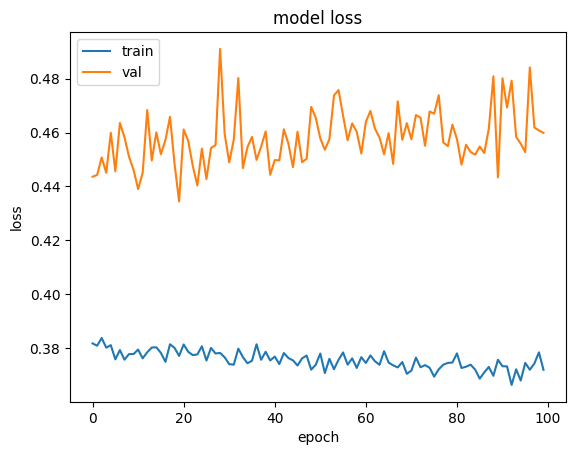

In [ ]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
history = siamese_model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[model_checkpoint_callback])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
siamese_model.load_weights(checkpoint_filepath)

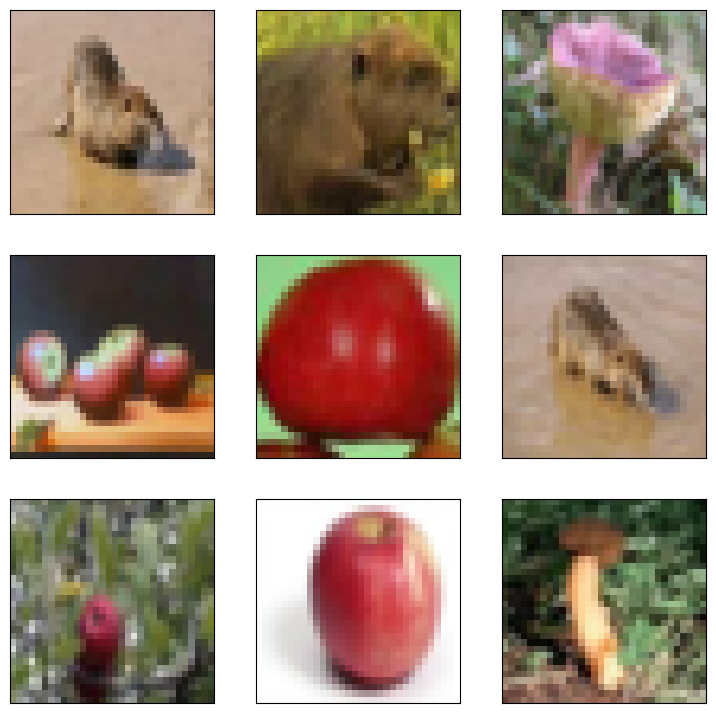

In [ ]:
sample = next(iter(train_dataset))
visualize(*sample)



anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(convnext.preprocess_input(anchor)),
    embedding(convnext.preprocess_input(positive)),
    embedding(convnext.preprocess_input(negative)),
)


In [ ]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.99961805
Negative similarity 0.99955165


In [ ]:
def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

dataset_images_path = Path.cwd() / "datasets/cifar/cifar-100-python/cifarTraining_png_images/KnnTrain"
dataset_images = sorted(
    [str(dataset_images_path / f) for f in os.listdir(dataset_images_path)])
dataset = tf.data.Dataset.from_tensor_slices(dataset_images)
data = iter(dataset.map(preprocess_image).batch(32, drop_remainder=False).prefetch(tf.data.AUTOTUNE))
databatch = next(data)

feat_list = embedding(convnext.preprocess_input(databatch)).numpy()

for i in range(624):
    databatch = next(data)
    feat_list = np.concatenate((feat_list,embedding(convnext.preprocess_input(databatch)).numpy()), axis = 0)


#feat_list = np.array(feat_list)

In [ ]:
normfeat_list = normalize(feat_list, axis=1)

In [ ]:
#Save feat_list
np.save('/content/drive/MyDrive/CC_Thesis_DP/datasets/cifar/cifar-100-python/siamesefeat_list_array', normfeat_list)

In [ ]:
#load feat_list
feat_list = np.load('datasets/imagenet/siamesefeat_list_array.npy')

In [ ]:
file3 = Path.cwd() / 'datasets/cifar/cifar-100-python/cifarTraining_png_images/KnnTrain.txt'
#file.read_text()

    # Open the file in "read" mode ('r')
with open(file3, 'r') as text:
    textfile3 = text.read()


textfile3 = textfile3.split('\n')
textfile3.pop()
labelsTrain = np.array(textfile3)


file4 = Path.cwd() / 'datasets/cifar/cifar-100-python/cifarTraining_png_images/KnnOpti.txt'
#file.read_text()

    # Open the file in "read" mode ('r')
with open(file4, 'r') as text:
    textfile4 = text.read()


textfile4 = textfile4.split('\n')
textfile4.pop()

labelsOpti = np.array(textfile4)
labelsTrain = labelsTrain.astype(int)
#labelsOpti = labelsOpti[44999:]

In [ ]:
neighlist = []


for i in range(1,161,8):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(normfeat_list, labelsTrain)
    neighlist.append(neigh)


In [ ]:
dataset_images_path = Path.cwd() / "datasets/cifar/cifar-100-python/cifarTraining_png_images/KnnOpti"
dataset_images = sorted(
    [str(dataset_images_path / f) for f in os.listdir(dataset_images_path)])
dataset = tf.data.Dataset.from_tensor_slices(dataset_images)
data = iter(dataset.map(preprocess_image).batch(32, drop_remainder=False).prefetch(tf.data.AUTOTUNE))
databatch = next(data)

feats = embedding(convnext.preprocess_input(databatch)).numpy()

for i in range(155):
    databatch = next(data)
    feats = np.concatenate((feats,embedding(convnext.preprocess_input(databatch)).numpy()), axis = 0)



In [ ]:
#feats.shape
normfeats = normalize(feats,axis=1)
#for i in range(len(feats)):
 #   normfeats[i,:] = normalize([feats[i,:]])[0]

In [ ]:
preds = []

for neigh in neighlist:
    preds.append(neigh.predict_proba(normfeats))

In [ ]:
preds = np.array(preds)
preds.shape

(20, 4992, 100)

In [ ]:
top5hits = [0]*20
top1hits = [0]*20

for i in range(20):
    for j in range(4992):

        if i <5:
            k = i+1
        else:
            k = 5

        top5indices = np.argpartition(preds[i][j], -k)[-k:]

        if np.int64(int(labelsOpti[j])) in top5indices:
            top5hits[i]+=1
            if np.int64(int(labelsOpti[j])) == np.argmax(preds[i][j]):
                top1hits[i] +=1

In [ ]:
top1hits,top5hits

([291,
  259,
  302,
  361,
  355,
  364,
  381,
  388,
  390,
  388,
  384,
  388,
  396,
  402,
  412,
  409,
  427,
  425,
  408,
  401],
 [291,
  495,
  737,
  948,
  1122,
  1160,
  1172,
  1199,
  1217,
  1235,
  1243,
  1277,
  1278,
  1266,
  1286,
  1282,
  1294,
  1300,
  1295,
  1288])